# Using a Neural Network to recognize execution patterns using hardware performance counters

Load libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from livelossplot.keras import PlotLossesCallback
from sklearn.utils import shuffle

dataset = pd.read_csv('data.csv',sep=';')

Using TensorFlow backend.
/home/ssleder/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ssleder/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ssleder/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ssleder/.local/lib/python3.6/site-packages/tensorflow/py

Shuffle data, necessary to mix the rows in the dataset in order to have training and testing data with all the cases.
If the data is not shuffled, the cur for the test7train pair will be done at exacty the x-th position in the dataset.

In [2]:
dataset = dataset.dropna()
dataset = shuffle(dataset)

Perform a 20/80 split for a testing and training set. Then get unique vector sizes in the testing set

In [3]:
msk = np.random.rand(len(dataset)) < 0.8

dataset_train = dataset[msk]

# full dataset to keep the 'size_vector' column in for testing
dataset_test_full = dataset[~msk]
dataset_test = dataset_test_full.copy(deep=True)

sizes_list = sorted(dataset_test_full.size_vector.unique())
unique_sizes = np.zeros((len(sizes_list), 3))
unique_sizes[:,0] = sizes_list

Remove extra columns and hardware performance counters discarded with PCA

In [4]:
def erase_from_dataset(dataset_in):
    del dataset_in['id']
    del dataset_in['size_vector']
    del dataset_in['comp_opt']
    del dataset_in['PAPI_BR_INS']
    del dataset_in['PAPI_BR_NTK']
    del dataset_in['PAPI_BR_PRC']
    del dataset_in['PAPI_FP_INS']
    del dataset_in['PAPI_L2_DCA']
    del dataset_in['PAPI_L2_DCM']
    del dataset_in['PAPI_L2_DCR']
    del dataset_in['PAPI_L2_DCW']
    del dataset_in['PAPI_L3_DCA']
    del dataset_in['PAPI_L3_DCR']
    del dataset_in['PAPI_L3_DCW']
    del dataset_in['PAPI_L3_LDM']
    del dataset_in['PAPI_LST_INS']
    del dataset_in['PAPI_RES_STL']
    del dataset_in['PAPI_TOT_CYC']
    del dataset_in['PAPI_L1_ICA']
    del dataset_in['PAPI_L1_ICH']
    del dataset_in['PAPI_L1_ICM']
    del dataset_in['PAPI_L1_ICR']
    del dataset_in['PAPI_L1_TCM']
    del dataset_in['PAPI_L2_ICA']
    del dataset_in['PAPI_L2_ICH']
    del dataset_in['PAPI_L2_ICM']
    del dataset_in['PAPI_L2_ICR']
    del dataset_in['PAPI_L2_TCA']
    del dataset_in['PAPI_L2_TCH']
    del dataset_in['PAPI_L2_TCM']
    del dataset_in['PAPI_L2_TCR']
    del dataset_in['PAPI_L2_TCW']
    del dataset_in['PAPI_L3_ICA']
    del dataset_in['PAPI_L3_ICR']
    del dataset_in['PAPI_L3_TCA']
    del dataset_in['PAPI_L3_TCR']
    del dataset_in['PAPI_L3_TCW']
    del dataset_in['PAPI_TLB_IM']
    del dataset_in['PAPI_TLB_TL']
    del dataset_in['PAPI_TOT_IIS']

    dataset_in = dataset_in.reset_index(drop=True)
    
erase_from_dataset(dataset_train)
erase_from_dataset(dataset_test)


Divide dataset hardware performance counters and labels

In [5]:
dataset_train = dataset_train.dropna()

X = dataset_train.iloc[:,1:21].values
y = dataset_train.iloc[:,0].values

Normalize data

In [6]:
from sklearn.preprocessing import Normalizer
scaler_x = Normalizer()
scaler_x.fit(X)
X_scaled =  scaler_x.transform(X)

Encode labels in numeric categories

In [7]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values

Load keras NN libraries and create empty NN

In [8]:
#Defining the model 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

model = Sequential()

Add input layer for the 20 hardware counters
Add one hidden layer
And one output layer
Then compile the model

In [9]:
#model.add(Dropout(0.1,input_shape=(20,)))
model.add(Dense(24,input_shape=(20,),activation='selu'))
#model.add(Dropout(0.2))
model.add(Dense(28,activation='selu'))
#model.add(Dropout(0.2))
model.add(Dense(16,activation='selu'))
#model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))
model.compile(Adam(lr=0.002),'categorical_crossentropy', metrics=['accuracy', 'mean_squared_error'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_2 (Dense)              (None, 28)                700       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
Total params: 1,736
Trainable params: 1,736
Non-trainable params: 0
_________________________________________________________________


Execute training the neural network set to live-plot the loss.

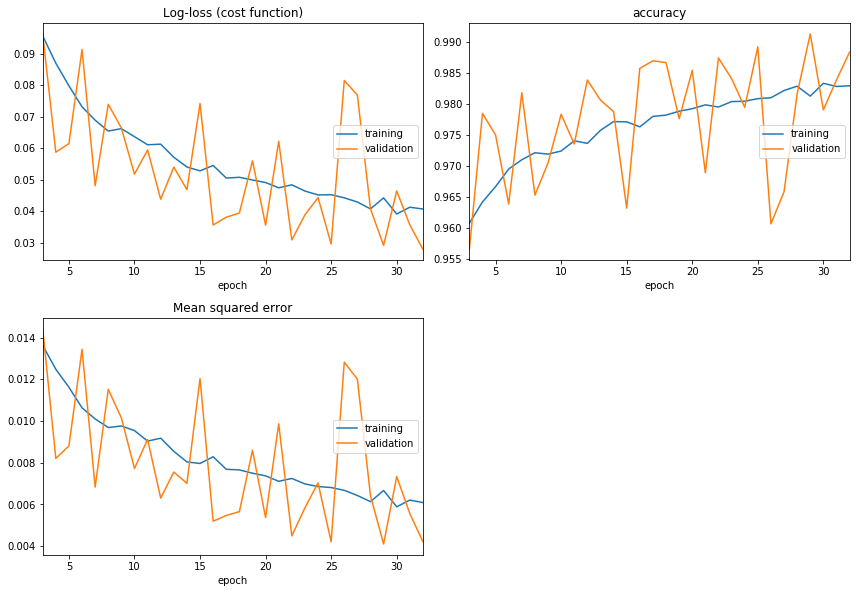

Log-loss (cost function):
training   (min:    0.039, max:    0.367, cur:    0.041)
validation (min:    0.028, max:    0.192, cur:    0.028)

accuracy:
training   (min:    0.850, max:    0.983, cur:    0.983)
validation (min:    0.922, max:    0.991, cur:    0.988)

Mean squared error:
training   (min:    0.006, max:    0.050, cur:    0.006)
validation (min:    0.004, max:    0.027, cur:    0.004)


In [10]:
plot_losses = PlotLossesCallback()
history = model.fit(X_scaled,Y,batch_size=128,epochs=32,shuffle=2,validation_split=0.20, callbacks=[plot_losses])

Check the % of correct and incorrect predictions

In [11]:
def predict(test_set):
    X_pred = test_set.iloc[:,1:21].values
    y_pred = test_set.iloc[:,0].values

    X_pred_scaled = scaler_x.fit_transform(X_pred)
    
    predictions = model.predict_classes(X_pred_scaled)
    prediction_ = np.argmax(to_categorical(predictions), axis = 1)
    prediction_ = encoder.inverse_transform(prediction_)
    
    pred_correct=0
    pred_incorrect=0
    for i, j in zip(prediction_ , y_pred):
        if (i==j):
            pred_correct = pred_correct+1
        else:
            pred_incorrect = pred_incorrect+1
            
    return pred_correct, pred_correct*100/(pred_correct+pred_incorrect), \
            pred_incorrect, pred_incorrect*100/(pred_correct+pred_incorrect)

Get the overall testing set accuracy

In [12]:
pc, ppc, pi, ppi = predict(dataset_test)

print("Correct predictions= {} ({}%)".format(pc,ppc))
print("Incorrect predictions= {} ({}%)".format(pi, ppi))

Correct predictions= 84125 (98.81248825408758%)
Incorrect predictions= 1011 (1.1875117459124225%)


In [13]:
for x, size in enumerate(unique_sizes):
    size_test_set = dataset_test_full[dataset_test_full['size_vector'] == size[0]]
    erase_from_dataset(size_test_set)
    _, unique_sizes[x][1], _, unique_sizes[x][2] = predict(size_test_set)

Plot the prediction accuracy for each size vector

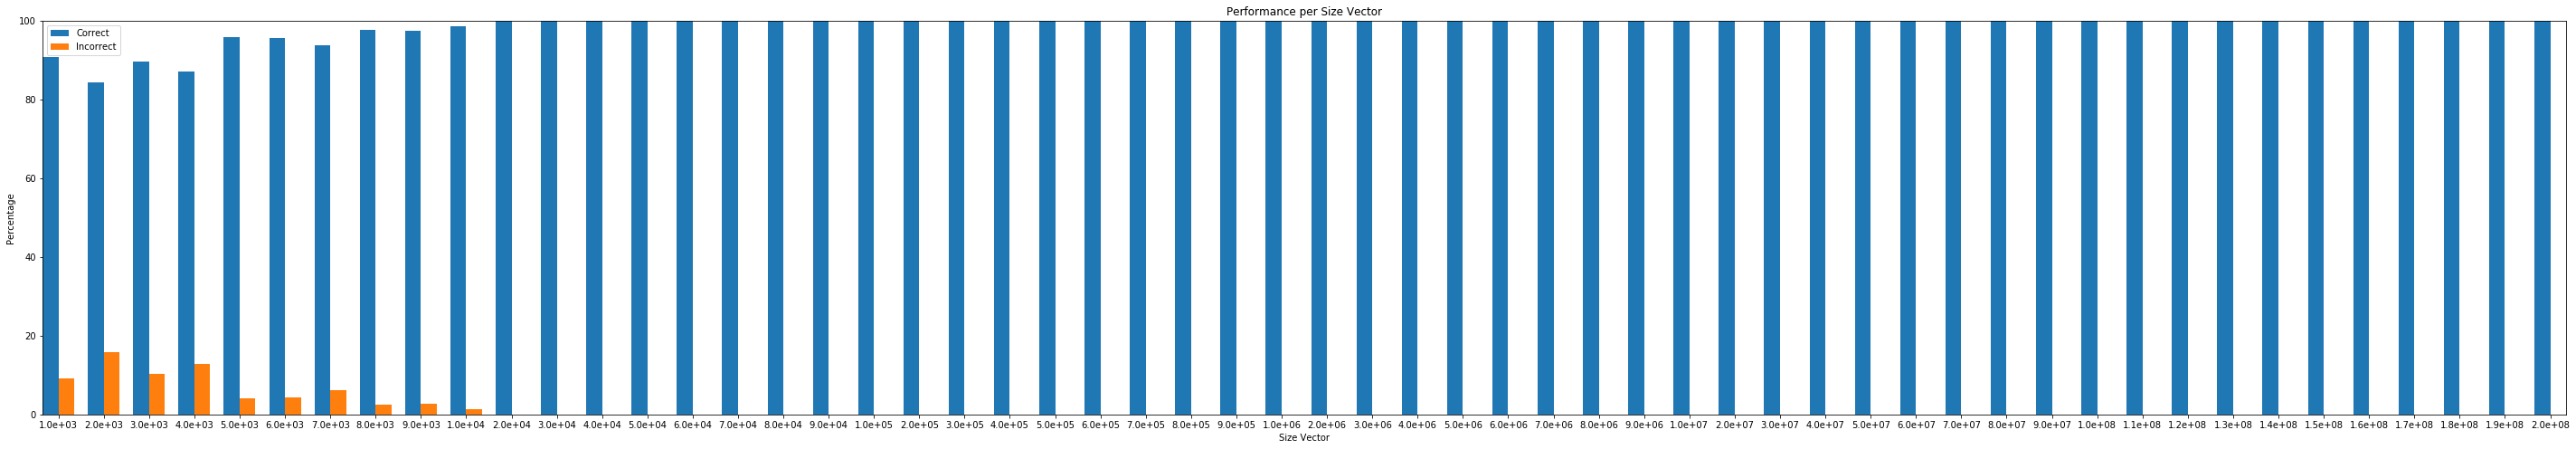

In [14]:
# get the numpy elements to convert to strings in scientific notation (for space reasons)
labels = [np.format_float_scientific(size, unique=False, precision=1) for size in unique_sizes[:,0]]
correct = unique_sizes[:,1]
incorrect = unique_sizes[:,2]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(50,8))
rects1 = ax.bar(x - width/2, correct, width, label='Correct')
rects2 = ax.bar(x + width/2, incorrect, width, label='Incorrect')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_xlabel('Size Vector')
ax.set_title('Performance per Size Vector')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.margins(0)

plt.show()